In [30]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.collections
from typing import Any
import math
import json
import matplotlib
import importlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
# sns.set_context("poster", font_scale=0.75)
sns.set_context("poster", font_scale=1.3)
sns.set_palette("colorblind6")

import plot
importlib.reload(plot)
visualize_stream = plot.visualize_stream
load_streams = plot.load_streams
visualize_ftq = plot.visualize_ftq
load_ftqs = plot.load_ftqs


# STREAM

In [14]:
stream, stream_meta = load_streams(Path("latest"), list(plot.DRIVER_MAP.keys()))

(<seaborn.axisgrid.FacetGrid at 0x7f115fca8250>,
          IterTime  Bandwidth  Cores          Driver
 0        0.068147  10.565404      1  virtio-balloon
 1        0.136142  10.589003      1  virtio-balloon
 2        0.204512  10.530919      1  virtio-balloon
 3        0.272683  10.561672      1  virtio-balloon
 4        0.340720  10.582509      1  virtio-balloon
 ...           ...        ...    ...             ...
 10741  107.155188  72.339838     12        Baseline
 10742  107.165122  72.478733     12        Baseline
 10743  107.175103  72.137660     12        Baseline
 10744  107.185031  72.522247     12        Baseline
 10745  107.194980  72.369309     12        Baseline
 
 [133360 rows x 4 columns])

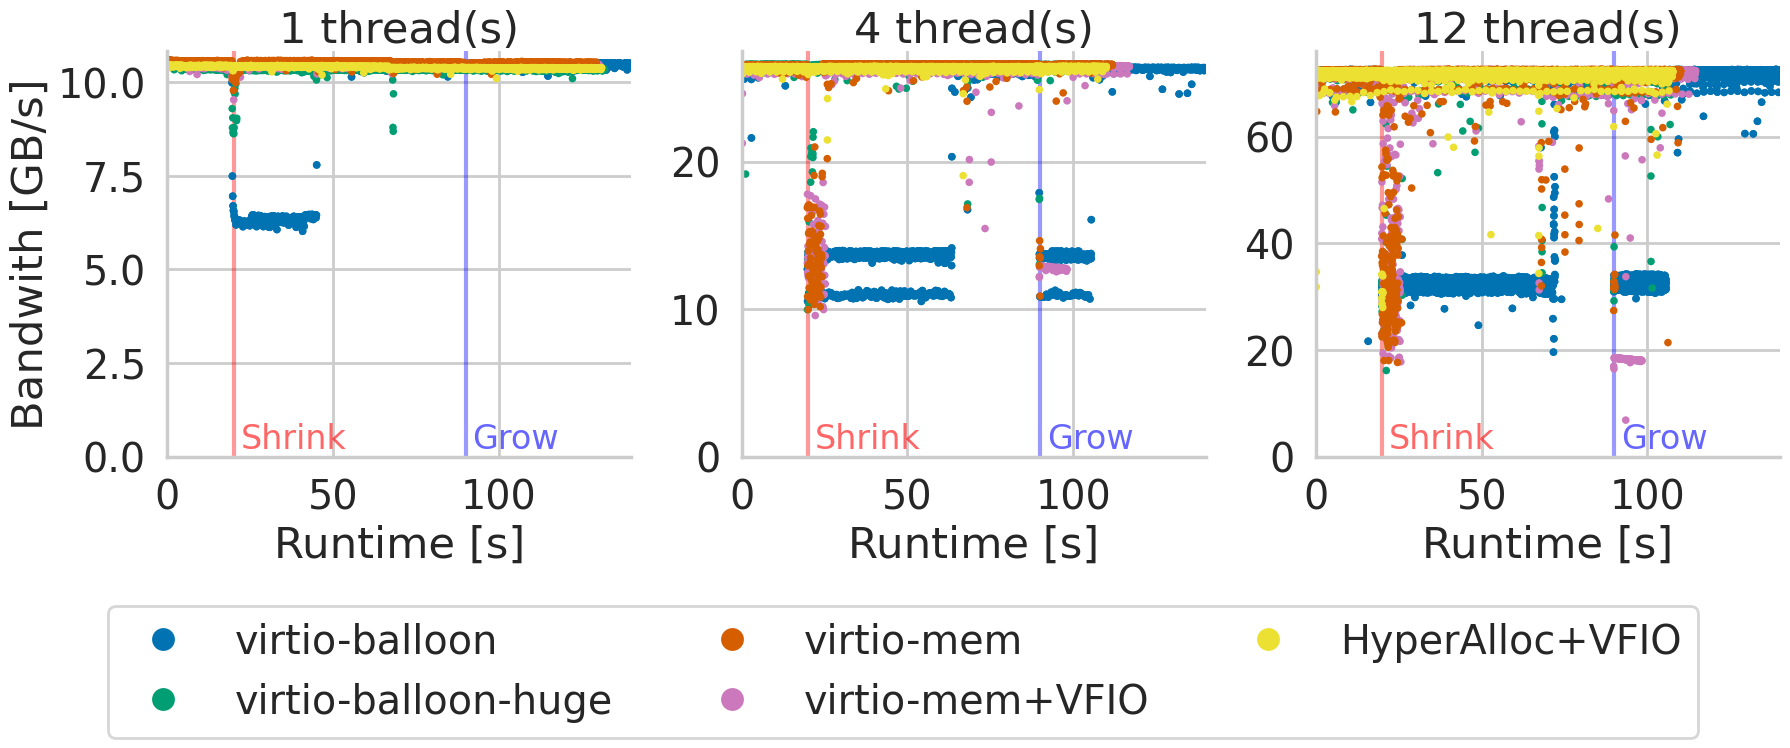

In [15]:
visualize_stream(
    [
        "virtio-balloon",
        "virtio-balloon-huge",
        "virtio-mem",
        "virtio-mem+VFIO",
        "HyperAlloc+VFIO",
    ],
    stream,
    stream_meta,
    "stream",
)

In [17]:
percentile = stream[["Cores", "Driver", "Bandwidth"]][(stream["Cores"] == 1) | (stream["Cores"] == 4) | (stream["Cores"] == 12)].groupby(["Cores", "Driver"]).quantile(0.01)

plot.dref_dataframe("stream_percentile", Path("out"), ["Cores", "Driver"], percentile)
percentile

Bandwidth
Cores Driver                        
1     Baseline             10.302149
      HyperAlloc           10.317228
      HyperAlloc+VFIO      10.326146
      virtio-balloon        6.213905
      virtio-balloon-huge  10.087149
      virtio-mem           10.230609
      virtio-mem+VFIO      10.253598
4     Baseline             26.043777
      HyperAlloc           26.296870
      HyperAlloc+VFIO      26.081241
      virtio-balloon       10.901847
      virtio-balloon-huge  25.503378
      virtio-mem           13.050839
      virtio-mem+VFIO      12.627977
12    Baseline             68.994041
      HyperAlloc           70.069292
      HyperAlloc+VFIO      70.286437
      virtio-balloon       30.925110
      virtio-balloon-huge  67.801951
      virtio-mem           31.897693
      virtio-mem+VFIO      18.368992

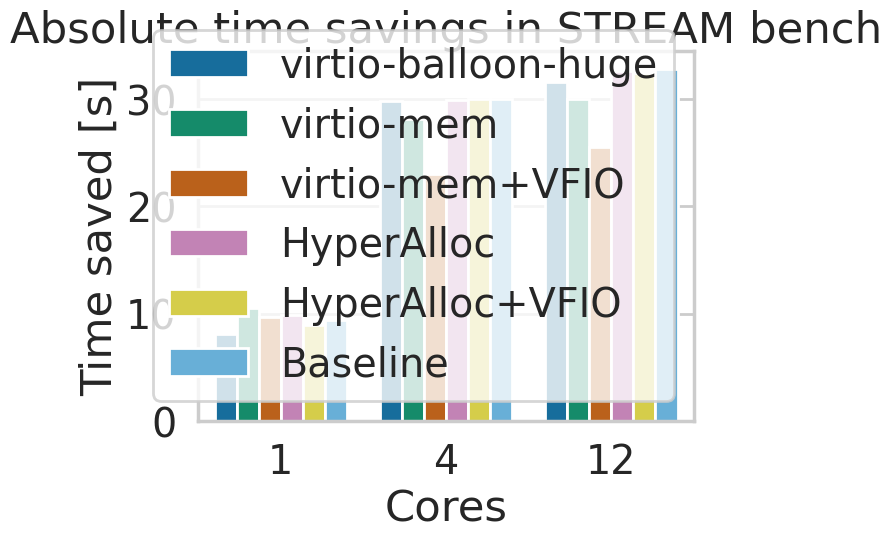

In [28]:
def calc_stream_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["virtio-balloon-huge", "virtio-mem", "virtio-mem+VFIO", "HyperAlloc", "HyperAlloc+VFIO", "Baseline"]
    for c in cores:
        core_data = stream.loc[stream["Cores"] == c]
        virtio_balloon = core_data.loc[core_data["Driver"] == "virtio-balloon"]
        long_time = virtio_balloon["IterTime"].max()
        times = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            times.append(long_time - driver_data["IterTime"][len(long_time - driver_data["IterTime"])-1])

        frames.append(pd.DataFrame({"Faster": times, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


stream_speedz = calc_stream_speedz([1, 4, 12])
plot.dref_dataframe("stream-speed", Path("out"), ["Cores", "Driver"], stream_speedz)

p = sns.barplot(data=stream_speedz, x="Cores", y="Faster", hue="Driver")
p.set_ylabel("Time saved [s]")
p.set_xlabel("Cores")
p.set_title(f"Absolute time savings in STREAM bench")
p.get_legend().set_title("")
sns.move_legend(p, "lower right")

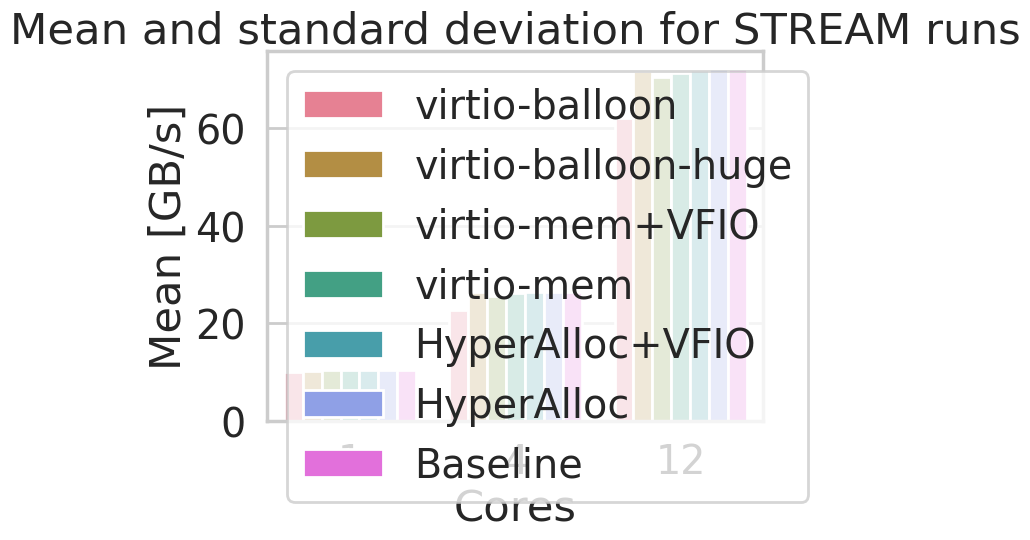

In [22]:
stream_stats = plot.calc_stats(stream, [1, 4, 12], "Bandwidth", list(plot.DRIVER_MAP.keys()))
plot.dref_dataframe_multi("stream-stats", Path("out"), ["Cores", "Driver"], ["Mean", "Std"], stream_stats)
pl = sns.barplot(data=stream_stats, x="Cores", y="Mean", hue="Driver")
# x_coords = [p.get_x() + 0.5 * p.get_width() for p in pl.patches]
# y_coords = [p.get_height() for p in pl.patches]
# pl.errorbar(x=x_coords, y=y_coords, yerr=stream_stats["Std"], fmt="none", c="k")
pl.set_ylabel("Mean [GB/s]")
pl.set_xlabel("Cores")
pl.set_title(f"Mean and standard deviation for STREAM runs")
pl.get_legend().set_title("")
sns.move_legend(pl, "upper left")

# FTQ

In [31]:
ftq, ftq_meta = load_ftqs(Path("latest"), list(plot.DRIVER_MAP.keys()))

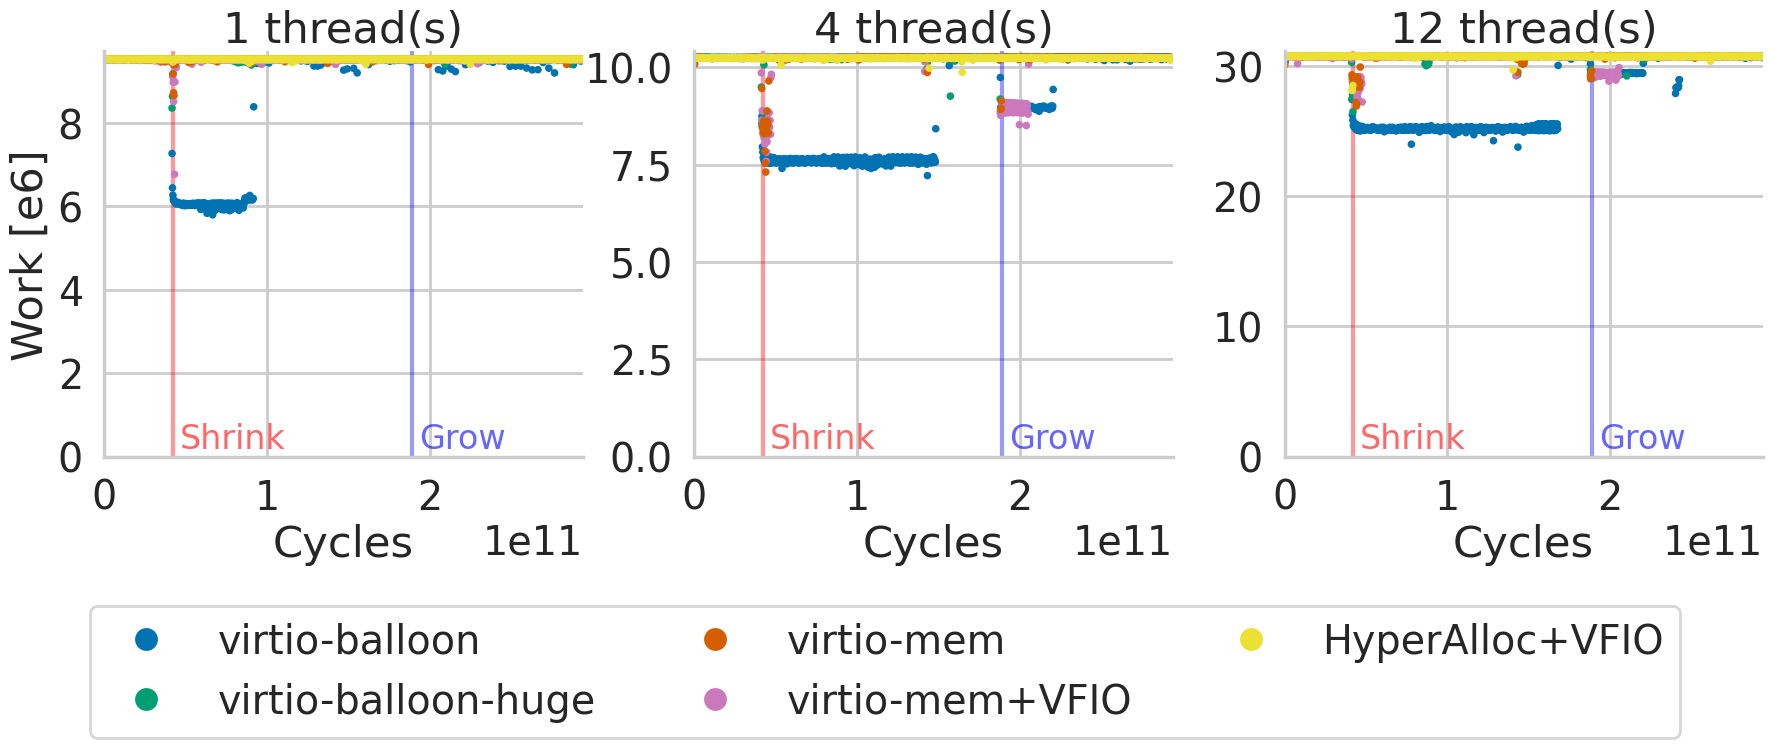

In [32]:
visualize_ftq(
    [
        "virtio-balloon",
        "virtio-balloon-huge",
        "virtio-mem",
        "virtio-mem+VFIO",
        "HyperAlloc+VFIO",
    ],
    ftq,
    ftq_meta,
    "ftq",
)

In [34]:
percentile = ftq[["Cores", "Driver", "Counts"]][(ftq["Cores"] == 1) | (ftq["Cores"] == 4) | (ftq["Cores"] == 12)].groupby(["Cores", "Driver"]).quantile(0.01)

plot.dref_dataframe("ftq_percentile", Path("out"), ["Cores", "Driver"], percentile)
percentile

Counts
Cores Driver                          
1     Baseline              9448837.62
      HyperAlloc            9498493.86
      HyperAlloc+VFIO       9501345.02
      virtio-balloon        5928255.04
      virtio-balloon-huge   9456490.42
      virtio-mem            9455050.92
      virtio-mem+VFIO       9416442.98
4     Baseline             10215082.78
      HyperAlloc           10218937.62
      HyperAlloc+VFIO      10212312.90
      virtio-balloon        7475934.86
      virtio-balloon-huge  10129648.50
      virtio-mem            8574017.12
      virtio-mem+VFIO       8401878.24
12    Baseline             30627562.40
      HyperAlloc           30686425.36
      HyperAlloc+VFIO      30679454.18
      virtio-balloon       24942490.36
      virtio-balloon-huge  30148171.80
      virtio-mem           28734129.34
      virtio-mem+VFIO      28340112.94

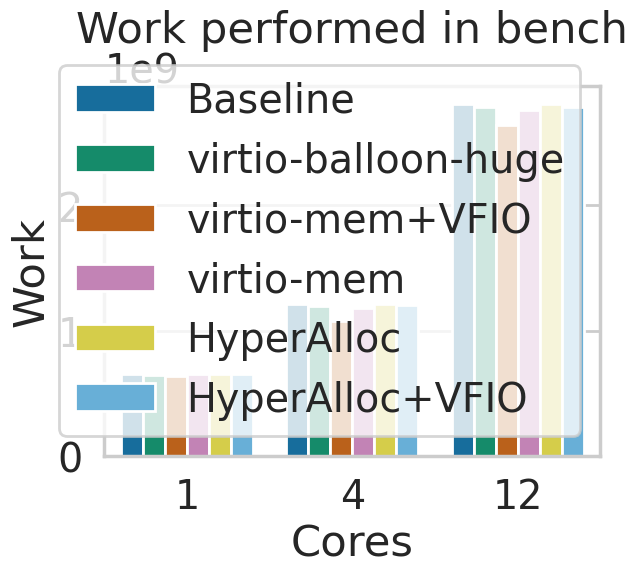

In [36]:
def calc_ftq_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["Baseline", "virtio-balloon-huge", "virtio-mem+VFIO", "virtio-mem", "HyperAlloc", "HyperAlloc+VFIO"]
    for c in cores:
        core_data = ftq.loc[ftq["Cores"] == c]
        base = core_data.loc[core_data["Driver"] == "virtio-balloon"]["Counts"].sum()
        work = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            work.append(driver_data["Counts"].sum() - base)

        frames.append(pd.DataFrame({"Work": work, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


ftq_speedz = calc_ftq_speedz([1, 4, 12])
plot.dref_dataframe("ftq-speed", Path("out"), ["Cores", "Driver"], ftq_speedz)

pl = sns.barplot(data=ftq_speedz, x="Cores", y="Work", hue="Driver")
pl.set_ylabel("Work")
pl.set_xlabel("Cores")
pl.set_title(f"Work performed in bench")
pl.get_legend().set_title("")
sns.move_legend(pl, "lower right")

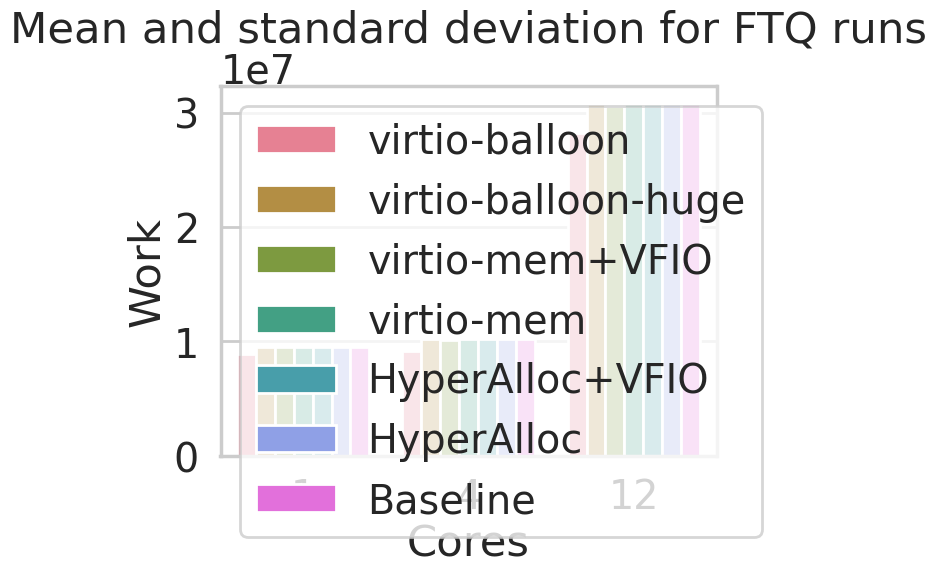

In [39]:
ftq_stats = plot.calc_stats(ftq, [1, 4, 12], "Counts", list(plot.DRIVER_MAP.keys()))
plot.dref_dataframe_multi("ftq-stats", Path("out"), ["Cores", "Driver"], ["Mean", "Std"], ftq_stats)
pl = sns.barplot(data=ftq_stats, x="Cores", y="Mean", hue="Driver")
# x_coords = [p.get_x() + 0.5 * p.get_width() for p in pl.patches]
# y_coords = [p.get_height() for p in pl.patches]
# pl.errorbar(x=x_coords, y=y_coords, yerr=ftq_stats["Std"], fmt="none", c="k")
pl.set_ylabel("Work")
pl.set_xlabel("Cores")
pl.set_title(f"Mean and standard deviation for FTQ runs")
pl.get_legend().set_title("")
sns.move_legend(pl, "upper left")